# 探索意图

## 使用聚类探索意图

在这本笔记本中，我采用了前一本笔记本中经过预处理和标记的数据，并试图通过使用有意义的文档嵌入方法（这样我的模型就可以读取数据）和无监督学习方法（如K-Means、DBScan和LDA）为数据集中的每条推文分配标签。

我把我的意图分为几类，总共有11类。对于在看不见的数据上进行意图分类的成功NN训练，我认为每个意图1000个是有用的。

In [1]:
# We need more packages!
# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Unsupervised Learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import silhouette_score, silhouette_samples

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from sklearn.manifold import TSNE

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
import gensim
print(f'gensim: {gensim.__version__}')

# Doc2Vec
from nltk.tokenize import word_tokenize 
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Directory
import os
import yaml

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

# Reading in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)
    
# Loading in the already saved processed dataset
processed_inbound = pd.read_pickle('objects/processed_inbound.pkl')

# Representing my tokenized data as String documents and storing it into a variable
string_processed_inbound = processed_inbound.progress_apply(" ".join)

# We start with this data, here's the preview
processed_inbound.head()

Pandas: 1.4.3
Numpy: 1.23.2
gensim: 4.3.2


/var/folders/8z/_m3tlbk55sv4j8cl6sp2_7gw0000gn/T/ipykernel_38811/3873072998.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()  # Enable tracking of execution progress


0it [00:00, ?it/s]

  0%|          | 0/77175 [00:00<?, ?it/s]

0     [new, update, i️, make, sure, download, yester...
6     [hey, anyone, else, upgraded, io, issue, capit...
12    [hello, internet, someone, explain, symbol, ke...
13    [get, screenshot, say, iphonex, reserve, email...
15    [thank, update, phone, even, slow, barely, wor...
Name: inbound_text, dtype: object

# Tweet Collection With Clustering

### 1. Count Vectorization

The easiest way to represent a document as a vector is with a bagofwords CountVectorizer. This will turn each document to be a 1D array, which I think is a good starting point for putting into my clustering algorithms. Let's see how it does. 

The count vectorizer only accepts the Series if the document is represented as a String, not a tokenized list. This string form also represents each row as a document. That's ultimately what I need to do for my clustering to be effective, because each point needs to represent one sequence altogether, not vectorized individual words.

I set the min_df paramater to 5 to only include terms that occur more than 5 times in my Count Vectorized data.

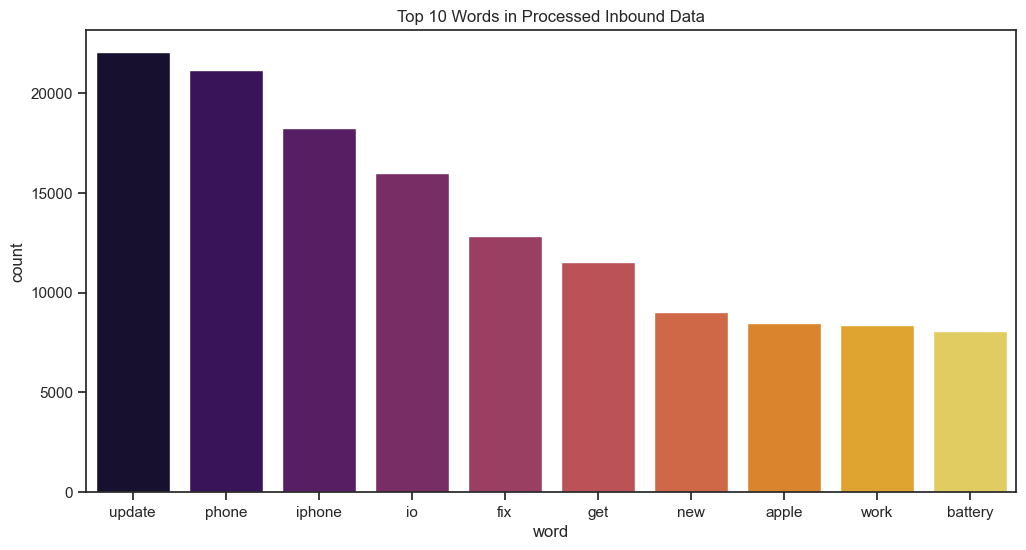

In [2]:
# Vectorizing the data with Count Vectorizer
bagofwords = CountVectorizer(min_df = 5).fit(string_processed_inbound)
inbound_cv = bagofwords.transform(string_processed_inbound)

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names_out())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()


top10_bagofwords(string_processed_inbound, 'initial_frequencies', 'Top 10 Words in Processed Inbound Data')

I mostly use count vectorizer to see top 10 words that occur in a particular dataset and visualize it here.

From the visualization above, this tells me most of the customer queries are about phones, particularly iOS and battery fixes. We also see thanks rank quite high, which is a good thing because it might indicate gratitude (which indicates a closing intent for my chatbot). Hi (rank 44) and hey (rank 25) classifies a greeting intent, and it's good to see that they appear a lot of times. Things are looking promising right now, but we wouldn't be able to see the quality until we actually start clustering.

### 2.TFIDF

In [3]:
tfidf = TfidfVectorizer(min_df=5, ngram_range = (1,3))
# Storing tfidf data and transforming them into sparse matrices
inbound_tfidf = tfidf.fit_transform(string_processed_inbound)
inbound_tfidf

<77175x34110 sparse matrix of type '<class 'numpy.float64'>'
	with 1259391 stored elements in Compressed Sparse Row format>

## Pretrained word embeddings

Bag of words lose many of the subtleties such as word ordering. This is why I will try these other text vectorization methods. These days we have more effective methods, especially since what I want to encode in these vectors are intent clusters.

### 3. GloVe
I am going to use multiple word embeddings to vectorize my text in different ways, and then test which one is the best word embedding to use, starting with the Glove word embedding. GloVe is an unsupervised learning algorithm for getting vector representations for words.

Gensim constrains pretrained word embeddings and have a special data format where you can basically load it in as a numpy array.

DISCLAIMER: I won't be using this one because my clustering algorithms only work when each tweet is one point, and this is a word transformer. I am leaving this part in my notebook as a progress log.

Useful sources for this step: 
* [Guide to word to vec word embeddings](https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92)
* Zeugma Docs
    * https://pypi.org/project/zeugma/0.41/
    * https://github.com/nkthiebaut/zeugma

In [4]:
glove = EmbeddingTransformer('glove')
# Applying it to the entire training data
inbound_glove = string_processed_inbound.progress_apply(glove.transform)
# Preview shapes
inbound_glove.iloc[0].shape, inbound_glove.iloc[1].shape

NameError: name 'EmbeddingTransformer' is not defined

As we can see, gloVe transforms individual sentences as multiple word vectors. We need an algorithm that transforms the entire sentence to one vector, so that it represents one point in space.

It's interesting, though, to play with this around conceptually even if we won't use it. We can check the cosine similarity between the first and second sentence should give you similarities across words in the sequence, which is interesting because it works when they are of different length.

In [ ]:
similarity = cosine_similarity(inbound_glove.iloc[0], inbound_glove.iloc[1])
similarity

As for intepretation, the cosine similarity could be 0 if the two vectors are perpendicular. And it seems that the similarity matrix takes the shape of the longer matrix that it compares.

## 4. Doc2Vec
Since this is the main embedding method I will use for my pipeline, I display how I capitalized this embedding in the next notebook.

## 5. Hugging Face
This is a startup that does a lot with NLP. I explore their encoders.

BERT wouldn't really be a good option because a large part of that was trained with Wikipedia data.

I am not sure what doc2vec is trained on, I think my results will be better if I find a Twitter based word embedding!

## 6. Fast-text 


# Scaling the Data

Before we cluster, let's make scaled versions of our dataset first, which would be good for distance-based clustering methods. In general, these vectors shouldn't really need scaling, but it may help for computational purposes. I only do this for my count vectorized and tfidf vectorized data, not ones with the more meaningful word embeddings.

In [5]:
# This is the data we have so far, they are stored in CSR compressed format
inbound_cv, inbound_tfidf

(<77175x4893 sparse matrix of type '<class 'numpy.int64'>'
 	with 768941 stored elements in Compressed Sparse Row format>,
 <77175x34110 sparse matrix of type '<class 'numpy.float64'>'
 	with 1259391 stored elements in Compressed Sparse Row format>)

In [6]:
# Fitting and transforming to create standard scaled versions of my data
inbound_cv_ma = MaxAbsScaler().fit_transform(inbound_cv)
inbound_tfidf_ma = MaxAbsScaler().fit_transform(inbound_cv)

inbound_cv_ma, inbound_tfidf_ma

(<77175x4893 sparse matrix of type '<class 'numpy.float64'>'
 	with 768941 stored elements in Compressed Sparse Row format>,
 <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
 	with 768941 stored elements in Compressed Sparse Row format>)

**训练考虑：**因为我将在项目的下一部分训练神经网络，所以我的目标是拥有大约10个意图（通过EDA，取决于数据中自然意图的实际数量）。对于这10个意图中的每一个，我想为每个意图提供大约1000个示例。我选择这个特定的数字是因为我希望每个意图的例子分布均匀，这样我就不会出现类不平衡，而且我的神经网络可以相对较好地对这十个类进行分类。


考虑到这一点，让探索开始吧！

我将尝试在我的数据上使用聚类方法和主题建模来提取主要主题并手动标记这些聚类。

如果我的数据都在同一类型的客户服务领域，我会取得更大的成功，而且我很小心地确保推特-苹果的数据是这样的。这样，我在下一个笔记本电脑中的模型将捕捉到意图分类的细微差别。一般来说，机器人会擅长用它所训练的语言谈论话题。

我知道，使用集群，您不能期望您的模型以预先集群的方式对数据进行集群。这是一个整体算法。我希望他们能神奇地将意图轻松地聚集在一起，然而现在可能就那么容易了！我们拭目以待。

## <font color='blue'>1. K Means</color>
我对单词向量进行聚类的第一种方法是K-Means，它往往在Blob上表现良好。

缺点是它非常慢，而且很难选择K的值——我甚至不知道数据中有多少意图。这就是为什么我从K的较大跳跃开始，以获得哪一个表现最好的更高层次的想法，然后我深入研究，最终决定什么K最适合在我的数据集中找到最佳意图数量。

## 1.1. 我的TFIDF和计数矢量化数据的K-Means
首先，我对TFIDF和计数矢量化数据进行了聚类。老实说，我不会真的期望它能带来好的结果，所以我不会花很多精力在这两个方面进行实际的聚类。但值得一试，以证明一种较老且次优的方法。

In [7]:
# Vectorized data
vectorized_data = {'inbound_cv_ma': inbound_cv_ma, 'inbound_tfidf_ma': inbound_tfidf_ma}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

0 ('inbound_cv_ma', <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
	with 768941 stored elements in Compressed Sparse Row format>)
1 ('inbound_tfidf_ma', <77175x4893 sparse matrix of type '<class 'numpy.float64'>'
	with 768941 stored elements in Compressed Sparse Row format>)


我正在对这里的所有数据运行我的整个K-Means。我正在对n_clusters进行超参数优化。第一个进度条是它如何处理数据集，第二个是它完成了所有n_clusters。

在缩放之前，我花了三个小时在10到100的10次迭代中对这两种数据类型应用K-Means。幸运的是，在我攀登之后，它训练得更快了。

我使用Python的序列化包Pickle将结果存储在这个单元格下面，这样我就不必再运行它了！

In [12]:
%%time
# My grand dictionaries that will store all my results
wcss_grand = {}
labels_grand = {}
silhouette_scores_grand = {}
# n_clusters = [10,20,30,40,50,60,70,80,90,100]
n_clusters = [10]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'models/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating grand dictionary
    wcss_grand[name + '_wcss'] = wcss
    labels_grand[name + '_labels'] = labels
    silhouette_scores_grand[name + '_silhouettes'] = silhouette_scores

# Saving all my results
with open('objects/wcss_grand.pkl', 'wb') as handle:
    pickle.dump(wcss_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_grand.pkl', 'wb') as handle:
    pickle.dump(labels_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects/silhouette_scores_grand.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_grand, handle, protocol=pickle.HIGHEST_PROTOCOL)

<timed exec>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Currently fitting inbound_cv_ma with 10 clusters... Please wait


<timed exec>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Currently fitting inbound_tfidf_ma with 10 clusters... Please wait
CPU times: user 3min 27s, sys: 1min 1s, total: 4min 29s
Wall time: 4min 14s


### Reading back in the results

In [13]:
# Storing it into objects I can use in this notebook

with open('objects/wcss_grand.pkl', 'rb') as handle:
    wcss_grand = pickle.load(handle)
with open('objects/labels_grand.pkl','rb') as handle:
    labels_grand = pickle.load(handle)
with open('objects/silhouette_scores_grand.pkl','rb') as handle:
    silhouette_scores_grand = pickle.load(handle)

## 寻找最佳K-Means模型

我正在画一个肘部图，看看是否有一个清晰的肘部，希望我能找到，但可能性不大。

我首先对**count个矢量化的**数据进行处理，然后对**tfidf**矢量化的数据进行处理：

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

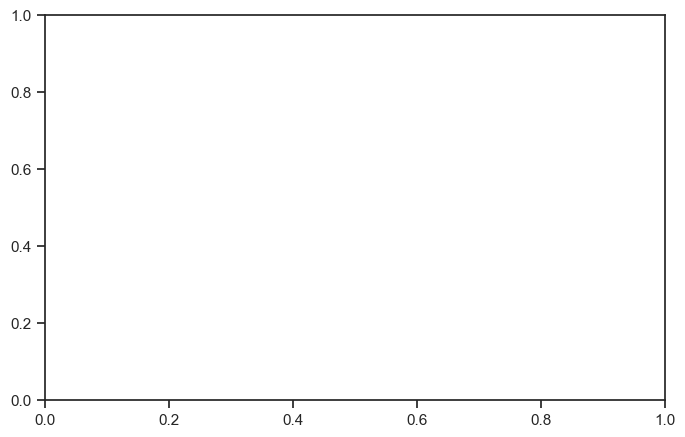

In [14]:
# Elbow Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_grand['inbound_cv_ma_wcss'], color = 'magenta')
plt.title('Elbow Method (Count Vectorized)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Elbow Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_grand['inbound_tfidf_ma_wcss'], color = 'magenta')
plt.title('Elbow Method (TFIDF)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot count vectorized
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_grand['inbound_cv_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (Count Vectorized)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot tfidf
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_grand['inbound_tfidf_ma_silhouettes'], color = 'red')
plt.title('Silhouette Method (TFIDF)')
plt.xlabel('Silhouette Score')
plt.ylabel('WCSS')
plt.show()

我们看到这些图在TFIDF和计数矢量化数据之间并没有太大变化，这进一步说明了我上面的说法，即它们并不是最有用的。

## 用t-SNE可视化我的集群

我尝试不同的颜色贴图并选择一个，这样更容易区分簇。

Available sequential colormaps:

```['viridis', 'plasma', 'inferno', 'magma', 'cividis']```

```['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']```

Available qualitative colormaps:
```['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']```

In [ ]:
# Current data
inbound_cv_ma.shape, inbound_tfidf_ma.shape

t-SNE是一个概率模型，所以这需要一些时间，特别是因为我们有大约80k行。

In [ ]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_cv_ma_tsne = tsne.fit_transform(inbound_cv_ma)

In [ ]:
# Plotting my visualization for each of my n_neighbors with my count vectorized data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_cv_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_cv_ma_tsne[:,0], inbound_cv_ma_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Count Vectorized Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

一开始我以为我真的看不到任何星团！但请记住，我有这么多数据点，所以我必须把这些集群做得很大。很酷的绘图，尽管我们的高维数据的2D表示不会非常准确，但我们还远远没有看到清晰的聚类！

我不希望它有太大的不同，但让我们看看我的TFIDF数据的相同图。

In [ ]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_tfidf_ma_tsne = tsne.fit_transform(inbound_tfidf_ma)

In [ ]:
# Plotting my visualization for each of my n_neighbors with my tfidf data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_tfidf_ma-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_tfidf_ma_tsne[:,0], inbound_tfidf_ma_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my TFIDF Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

果不其然，这些看起来真的很像计数矢量化集群！让我们继续讨论单词嵌入集群，我认为这更有趣。

## 1.2. K-Means for my Doc2Vec data

请注意，我没有故意缩放d2v数据，因为我不想扭曲预训练模型创建的距离。

In [ ]:
# Vectorized data
vectorized_data = {'inbound_cv_d2v': inbound_d2v}
# Briefly showing the contents of i and j
for i,j in enumerate(vectorized_data.items()): print(i,j);

In [ ]:
# My d2v dictionaries that will store all my results
wcss_d2v = {}
labels_d2v = {}
silhouette_scores_d2v = {}
n_clusters = [10,20,30,40,50,60,70,80,90,100]

# Iterating through all the differently embedded data
for i,j in tqdm(enumerate(vectorized_data.items())): 
    name = j[0] # Here j[0] is the name of the dataset
    dataset = j[1] # And j[1] is the actual data
    
    # I store my metrics at these following lists
    wcss = []
    labels = []
    silhouette_scores = []
    
    # Looping through values of k
    for k in tqdm(n_clusters):    
        print(f'Currently fitting {name} with {k} clusters... Please wait')
        
        # Initializing with k-means++ ensures that you get don’t fall into the random initialization trap.
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state = 10)
        kmeans.fit(dataset)
        wcss.append(kmeans.inertia_)
        
        # Getting the silhouette score
        labels.append(kmeans.labels_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))
        
        # Saving the models
        filename = f'models/kmeans/{name}-{k}neighbors.sav'
        joblib.dump(kmeans, filename)
        
    # Updating d2v dictionary
    wcss_d2v[name + '_wcss'] = wcss
    labels_d2v[name + '_labels'] = labels
    silhouette_scores_d2v[name + '_silhouettes'] = silhouette_scores

# Saving all my results, now with a d2v tag
with open('objects/wcss_d2v.pkl', 'wb') as handle:
    pickle.dump(wcss_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('objects/labels_d2v.pkl', 'wb') as handle:
    pickle.dump(labels_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('objects/silhouette_scores_d2v.pkl', 'wb') as handle:
    pickle.dump(silhouette_scores_d2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Reading back in the results.

In [ ]:
# Storing it into objects I can use in this notebook

with open('objects/wcss_d2v.pkl', 'rb') as handle:
    wcss_d2v = pickle.load(handle)
with open('objects/labels_d2v.pkl','rb') as handle:
    labels_d2v = pickle.load(handle)
with open('objects/silhouette_scores_d2v.pkl','rb') as handle:
    silhouette_scores_d2v = pickle.load(handle)

Here are my plots:

In [ ]:
# Elbow Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), wcss_d2v['inbound_cv_d2v_wcss'], color = 'magenta')
plt.title('Elbow Method (Doc2Vec)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silouette Plot d2v
plt.figure(figsize=(8,5))
plt.plot(range(10, 101, 10), silhouette_scores_d2v['inbound_cv_d2v_silhouettes'], color = 'red')
plt.title('Silhouette Method (Doc2Vec)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Great, now we see that we have a slightly higher silhouette score which isn't negative now. It looks like K = 20 would be the best in this case as it has the highest silhouette score and there is sort of an elbow in the elbow plot, definitely more than at 80 clusters where it seems to be completely smooth.

In [ ]:
%time
# Instantiate t-SNE
tsne = TSNE(n_components=2, random_state=1, n_jobs=-1)

# Fit t-SNE
inbound_d2v_tsne = tsne.fit_transform(inbound_d2v)

In [ ]:
# Plotting my visualization for each of my n_neighbors, now with Doc2Vec embedded data

for k in range(10,101,10):
    # Getting the right K-Means cluster labels.
    labels = joblib.load(f'models/kmeans/inbound_cv_d2v-{str(k)}neighbors.sav').labels_
    
    # Visualize high-dimensional data
    plt.figure(figsize=(13,12))
    plt.scatter(inbound_d2v_tsne[:,0], inbound_d2v_tsne[:,1], s=20, c = labels, cmap = 'magma')
    plt.title(f'2-D t-SNE Representation of my Doc2Vec Inbound data with {k} Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

基于t-SNE图很难判断，因此，我将在后面的部分通过实际查看标签来评估它是如何聚集的！

## <font color = 'blue'>2. LDA (Latent Dirichlet Allocation) </color>
我的第二种聚类方法是LDA主题建模。它基本上会获取您的数据并将其拆分为多个主题。我的目标仍然是集群，但通过这种方法，我希望获得更有用、更独特的主题。


Useful articles:
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05

还有一些新的、基于深度学习的方法，称为LDA2Vec，也可能很有兴趣探索。

然而，由于比例的变化，我将把这一步作为未来的一步。

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

In [ ]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
with open(LDAvis_data_filepath, 'w') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

出于时间限制的考虑，我决定不使用DBScan，因为它们将获得类似于K-Means的聚类结果。我也可以使用高斯混合模型或Heirarchical聚类来实现这个聚类结果。

## 发现并可视化集群之间的意图差异

我把我所有的模型都保存在这个名为文件夹的目录中的一个文件夹中。我所要做的就是为该模型选择一个超参数设置，并可视化这些聚类中的单词。

In [ ]:
processed_inbound

我认为查看集群中的前10个单词非常有用，可以很好地了解集群中的意图！

### Using scattertext from the spaCy universe for EDA
This [kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universehttps://www.kaggle.com/psbots/customer-support-meets-spacy-universe) showed me what spaCy's scattertext tool is capable of doing! So I wanted to do it myself as well to hopefully get useful insights.

正如文档中所说，散点文本是“一种在中小型语料库中找到区别术语的工具，并用不重叠的术语标签在性感的交互式散点图中呈现它们。”

这对于比较我在以下笔记本中的意图集群也非常有用。

In [ ]:
!ls models/kmeans

In [ ]:
labels = joblib.load(f'models/kmeans/inbound_cv_d2v-10neighbors.sav').labels_

# Scattertext for cluster evaluation

In [ ]:
corpus = st.CorpusFromParsedDocuments(love['Text'], category_col = 
                             parsed_col = 'parsed').build()

In [ ]:
# html = st.produce_scattertext_explorer(corpus,
#           category='British_Airways',
#           category_name='British Airways',
#           not_category_name='American Airlines',
#           width_in_pixels=600,
#           minimum_term_frequency=10,
#           term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
#           )

In [ ]:
# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)

In [ ]:
### Using scattertext from the spaCy universe for EDA
This [kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universehttps://www.kaggle.com/psbots/customer-support-meets-spacy-universe) showed me what spaCy's scattertext tool is capable of doing! So I wanted to do it myself as well to hopefully get useful insights.

As said in the docs, scatter-text is "a tool for finding distinguishing terms in small-to-medium-sized corpora, and presenting them in a sexy, interactive scatter plot with non-overlapping term labels."

This will be very useful for comparing my intent clusters in the following notebook as well.

corpus = st.CorpusFromParsedDocuments(processed_inbound,
                             parsed_col = 'parsed').build()

# html = st.produce_scattertext_explorer(corpus,
#           category='British_Airways',
#           category_name='British Airways',
#           not_category_name='American Airlines',
#           width_in_pixels=600,
#           minimum_term_frequency=10,
#           term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
#           )

# uncomment this cell to load the interactive scattertext visualisation
# filename = "americanAir-vs-britishAirways.html"
# open(filename, 'wb').write(html.encode('utf-8'))
# IFrame(src=filename, width = 800, height=700)def top10_bagofwords(data):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    inbound = bagofwords.fit_transform(data)
    inbound # Output will be a sparse matrix
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,8))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), color = 'salmon')
    plt.title('Top 10 Most Common Words in My Data')
    plt.show()

# My Approach: Heuristic Intent Distribution Exploration
I need to get an idea of how much true intents are inside my Twitter data. Doing it by keyword might prove to be a good baseline way to do this. I build off this idea, and do a heuristic clustering of my intents by trying to minimize intent intersections. I try to boil down with this method to have the most distinct and _mutually exclusive_ sets of intents so that Eve bot will be able to be trained to distinguish these intents.

I was inspired by seeing other solutions, such as the implementation by cortex, where they made a "semantic fingerprint" per intent. Obviously, the details of that are not shared, but it was enough for me to try to think of my own solution. Initially, I was going to stem off the clustering and try to manually pick out 1000 examples manually, but that is just not a smart idea and is extremely labor intensive.

This notebook is my way of getting my training data for intent classificaition.

In [ ]:
import pandas as pd
print(f'pandas: {pd.__version__}')
import numpy as np
print(f'numpy: {np.__version__}')
# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
# Making my visualizations pretty
sns.set_style('whitegrid')
# Combination exploration
import itertools
import yaml

# Loading back processed data
processed = pd.read_pickle('objects/processed.pkl')
print(f'\ninbound:\n{processed.head()}')

## Brief Keyword Search EDA
Using this as a tool to look at Tweets.

In [ ]:
# Search by keywords (single keyword filter)
keyword = 'info'

# Seeing what the processed Tweets look like
filt = [(i,j) for i,j in enumerate(processed['Processed Inbound']) if keyword in j]
filtered = processed.iloc[[i[0] for i in filt]]
print(f'{len(filtered)} Tweets contain the keyword {keyword}')
filtered

In [ ]:
[*filtered['Real Inbound']]

# My Intents:

<img src="visualizations/intent_list.png" alt="Drawing" style="width: 300px;"/>

下面这个单元格代表了我寻找意图的旅程。最后，下面的一切都是为了通知这个字典的选择，并随后创建我的训练数据。当我意识到我也可以将其与命名实体识别相结合时，它大大减少了。

你会注意到它并没有包含所有内容，这是因为有些意图不在我的训练数据中——它们必须手动创建。这方面的例子是问候语：这个训练数据不会只包含只有“嗨”的推文，它们几乎总是包含多个意图。

In [ ]:
# Post-hoc Intents: I find the keywords that is associated with intent and search based on these keywords

# Version 1 - Initial Mockup: Making a dictionary to store intents and the predefined responses

intents = {"Greeting": ["Hi there!","Hello"], 
 "Closing":"Thanks for talking", 
 "Promotion":"",
           "Scenarios": {'Last payment': "", "Account details":"", 
                         "Account confirmation": ""},
    "Location": ""}

# Version 2 - Just for showing progress
intents = {'greeting': ['hi', 'hello', 'hey','yo'], 'app': ['app', 'application'],
          'iphone': ['iphone', 'i phone'], 'icloud': ['icloud', 'i cloud'],
          'ios': ['io'], 'battery': ['battery'], 'watch': ['watch'], 'mac': 
           ['mac', 'macbook', 'laptop', 'computer'], 'update': ['update'],
          'troubleshooting': ['problem', 'trouble', 'error'],
          'settings': ['settings', 'setting'], 'music': ['music', 'song', 'playlist'],
          'payment': ['credit','card','payment','pay'], 'bug':['bug'], 'watch': ['tv', 'show'],
          'network': ['internet','connection','network']}

# Intents that require all words within it to be contained in the list (alternative filtering method)
intents_all = {'ios update': ['io', 'update'], 'app update': ['app','update']}

# Version 3
intents = {'update': ['update'], 'battery': ['battery', 'power'], 'forgot_password':['password','account','login'],
          'repair':['repair','fix','broken'],  
           'payment': ['credit','card','payment','pay']}

# Storing it to YAML file
with open('objects/intents.yml', 'w') as outfile:
    yaml.dump(intents, outfile, default_flow_style=False)

print('INTENTS FOR KEYWORD EDA BELOW:\n ------------------------')
for i in intents.items():
    print('Intent: {} \n   Keywords: {}'.format(i[0], " + ".join(i[1])))

### Useful functions I made. Will be very useful for the intent exploratory analysis.

In [ ]:
# Three different ways to filter out Tweets based on Keywords
# 1.
def get_key_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets that contains at least
    one of these keywords '''
    keyword_tweets = []
    for tweet in series:
        # Want to check if keyword is in tweets
        for keyword in keywords:
            if keyword in tweet:
                keyword_tweets.append(tweet)
    return keyword_tweets

# 2. Making a function that filters to Tweets that needs to have ALL the keywords
def all_key_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets have all the keywords'''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if all(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# 3. Making a function that filters to tweets that DONT contain any of the keywords
def key_absent_tweets(series, keywords):
    ''' Takes as input the list of keywords and outputs the Tweets that don't contain any
    of these keywords '''
    keyword_absent_tweets = []
    for tweet in series:
        # Want to check if keyword is not in tweets
        if not any(item in tweet for item in keywords):
            keyword_absent_tweets.append(tweet)
    return keyword_absent_tweets

# Getting a list of all my keywords so far
all_keywords = []
for keywords in intents.values():
    for keyword in keywords:
        all_keywords.append(keyword)      
        

def only_key_tweets(series, keywords):
    ''' Uses the all_keywords '''
    kept = list()
    for tweet in series:
        # Check
        if all(elem in tweet for elem in keywords):
            kept.append(tweet)
    return pd.Series(kept)
        
def to_set(l):
    ''' In order to make the Tweets a set to check for intersections, we need
    to make them immutable by making it a tuple because sets only accept immutable
    elements '''
    return set([tuple(row) for row in l])


### Intent Visualization

In [ ]:
# Using the function above to visualize the distribution of intents in my dataset

intent_lengths = [len(get_key_tweets(processed['Processed Inbound'], intents[intent])) for intent in intents.keys()]
keyword = pd.DataFrame({'intents': list(intents.keys()), 'intent_lengths': intent_lengths}).sort_values('intent_lengths', ascending = False)

# Visualization
plt.figure(figsize=(9,7))
plt.bar(keyword['intents'], keyword['intent_lengths'], color = '#00acee')
plt.title('Distribution of Intents Using Keyword Searching')
plt.xlabel('Intent')
plt.xticks(rotation=90)
plt.ylabel('Number of Tweets with the Intent Keywords')
plt.show()

# Proportions visualization
plt.figure(figsize=(9,7))
plt.bar(keyword['intents'], keyword['intent_lengths'] * 100 / 75879, color = '#00acee')
plt.title('Distribution of Intents Using Keyword Searching')
plt.xlabel('Intent')
plt.xticks(rotation=90)
plt.ylabel('Percentage of Tweets with the Intent Keywords')
# Saving
plt.savefig('visualizations/intent_distribution_keyword.png')
plt.show()

In [ ]:
# Seeing precise numeric counts
keyword

从这里来看，我们似乎没有足够的钱让最后两个意图获得1000，但这没关系，因为我可以稍后复制它们。

我还为至少包含一个问题的推文数量做了一个替代过滤器。在这次探索中，我发现在75879个总数中，27373个至少包含一个问号（36.1%）。

### 组合勘探

在这里，我想看看搜索到的不同类别之间有多少推文重叠。如果意图之间有太多的重叠，这意味着我们可以为特定的推文标记两个意图。我认为这仍然有效，尽管这意味着我们需要看看如何回应双重意图。

In [ ]:
# Initializing all the thresholds for min amount of combination appearances
thres = [500,10,5,5]

# Intent Tweets have all the keys, and as the value contains all the tweets that contain that key, as a set
intent_tweets = {}
for key in intents.keys():
    intent_tweets[key] = to_set(get_key_tweets(processed['Processed Inbound'],intents[key]))

# Iterating through all pairs, and getting how many Tweets intersect between the pair
keyword_overlaps = {}

# COMBINATIONS OF 2

# Each i returns a tuple containing a pair of length r, which in this case is 2
for i in list(itertools.combinations(list(intents.keys()),2)):
    a = to_set(intent_tweets[i[0]])
    b = to_set(intent_tweets[i[1]])
    # Inserting pair to dictionary
    keyword_overlaps[f"{i[0]} + {i[1]}"] = len(a.intersection(b))

# Filtering to just the significant ones, which I define as greater than 100
combs = []
counts = []
for i in keyword_overlaps.items():
    if i[1] > thres[0]:
        combs.append(i[0])
        counts.append(i[1])

# Visualizing as well
v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
plt.figure(figsize=(9,6))
sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
plt.title(f'Combinations of 2 Keywords (At Least {thres[0]} Occurances)')
plt.xticks(rotation=90)
plt.show()

# COMBINATIONS OF 3
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 3
    for i in list(itertools.combinations(list(intents.keys()),3)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]}"] = len(a.intersection(b).intersection(c))

    # Filtering to just the significant ones, which I define as greater than 100
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[1]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 3 Keywords (At Least {thres[1]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 3-combinations (Thres = {thres[1]})')
    
# COMBINATIONS OF 4
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 4
    for i in list(itertools.combinations(list(intents.keys()),4)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]}"] = len(a.intersection(b).intersection(c).intersection(d))

    # Filtering to just the significant ones, which I define as greater than 10
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[2]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 4 Keywords (At Least {thres[2]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 4-combinations (Thres = {thres[2]})')

# GROUPS OF 5
keyword_overlaps = {}

try:
    # Each i returns a tuple containing a pair of length r, which in this case is 5
    for i in list(itertools.combinations(list(intents.keys()),5)):
        a = to_set(intent_tweets[i[0]])
        b = to_set(intent_tweets[i[1]])
        c = to_set(intent_tweets[i[2]])
        d = to_set(intent_tweets[i[3]])
        e = to_set(intent_tweets[i[4]])
        # Inserting pair to dictionary
        keyword_overlaps[f"{i[0]} + {i[1]} + {i[2]} + {i[3]} + {i[4]}"] = len(a.intersection(b).intersection(c).intersection(d).intersection(e))

    # Filtering to just the significant ones, which I define as greater than 5
    combs = []
    counts = []
    for i in keyword_overlaps.items():
        if i[1] > thres[3]:
            combs.append(i[0])
            counts.append(i[1])

    # Visualizing as well
    v = pd.DataFrame({'Combination': combs, "Counts": counts}).sort_values('Counts', ascending = False)
    plt.figure(figsize=(9,6))
    sns.barplot(x = v['Combination'], y = v['Counts'], palette = 'magma')
    plt.title(f'Combinations of 5 Keywords (At Least {thres[3]} Occurances)')
    plt.xticks(rotation=90)
    plt.show()
except ValueError as e:
    print(f'Not enough 5-combinations (Thres = {thres[3]})')

我们在4的组合中看到，很明显，客户想问我们什么。出现407次的最高一次是（“手机记录+ios+电池+更新”）-这是客户想要为他们的iphone推荐关于他们的ios的内容，这是关于更新的内容。

这里甚至可以看到5的组合。

除了苹果自己的[@applesupport](https://twitter.com/AppleSupport)，还有什么比看看还有什么意图更好的地方推特页面？

* 我们看到，更新通常存在于许多组合中
* 大多数意图通常是一个又一个的组合！

我们可以看到，基于相似推文数量的绝对值，我们不会很难为每个意图类别找到1000个训练示例，尤其是更新！将较高的发生率分解为更细微、更独特的类别可能也是一个好主意。此外，我通常想使用超过1000条推文的意图，好消息是大多数意图每条推文都超过1000条。

# Special Cases
我想测试一下，可能会有用。

In [ ]:
# I wanted to group iOS update into one intent. 
# But since ios and update occured a lot other I put them together into one intent group. 

print('app intents without ios: {}'.format(len(key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']))))
key_absent_tweets(get_key_tweets(processed_inbound, intents['app']), ['io']);

# Exploration of combinations and "purity" of a cluster
print('both ios and update appears: {}'.format(6000))
print('just ios: {}'.format(len(get_key_tweets(processed_inbound, intents['ios']))))
print('ios but no update: {}'.format(len(get_key_tweets(processed_inbound, intents['ios'])) - 6000))

### 我想查找我在启发式搜索中没有考虑的所有推文
可能最有用的过滤器是这个。

In [ ]:
# Using the key absent function
key_absent_tweets(processed['Processed Inbound'].iloc, all_keywords)

从这里，我得到了解释的灵感：
* Settings
* Apple Music
* Phone
* Credit card

In [ ]:
only_key_tweets(processed_inbound, intents_all['ios update'])

In [ ]:
only_key_tweets(processed_inbound, ['app'])

In [ ]:
keyword

Settings might not be the best intent to try on.

In [ ]:
# Inspecting the Tweets with that specific keyword
len(get_key_tweets(processed_inbound, intents['greeting'])), 27373/75879

In [ ]:
get_key_tweets(processed_inbound, intents['app'])

In [ ]:
intents['greeting']

In [ ]:
processed_inbound.iloc[0:10]

## 捕获的意图
（这只是我认为意图的另一个版本-你可以看到这些意图有多个版本，因为这是一个迭代启发式优化过程）-实际上我花了一段时间才找到如何挖掘意图的好指南。

1. Greeting
2. App recommendations
    * Need to tag the actual appication we want
    * Need to tag the problem
3. Hardware recommendations
    * Phone hardware issue
    * Battery health
6. ICloud photos
7. Apple watch
8. Software (iOS)/ update bugs
9. Statement (not really asking for anything, it is just giving a statement about something) - If possible, I would like to remove these because they are not really that useful to me.
    * Opinions
    * Complaint
    * Thinking about this point further, it might be useful to include question marks in the data because that encodes useful information about whether or not a customer is making a question or not.
10. Want to purchase
11. Gratitude/Closing